TASK 1

MOVIE GENRE CLASSIFICATION (TF-IDF)

Problem Statement: Create a machine learning model that can predict the genre of a movie based on its plot summary or other textual information. You can use techniques like TF-IDF or word embeddings with classifiers such as Naive Bayes, Logistic Regression, or Support Vector Machines.

Task 1 : Import Libreries

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
from time import time
import re
import string
import nltk
#from googletrans import Translator
#from langdetect import detect
#import pycountry
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [6]:
#collect data
train = pd.read_csv(r"train_data.txt", sep=':::',names=['Title', 'Genre', 'Description']).reset_index(drop=True)
train.head()

,Title,Genre,Description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [7]:
test = pd.read_csv(r"test_data.txt", sep=':::',names=['Title', 'Description']).reset_index(drop=True)
test.head()

,Title,Description
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


Task 2 : Data Cleaning

In [11]:
train.describe(include='object').T

,count,unique,top,freq
Title,54214,54214,Oscar et la dame rose (2009),1
Genre,54214,27,drama,13613
Description,54214,54086,Grammy - music award of the American academy ...,12


In [12]:
#no null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [13]:
train.duplicated().sum()

0

In [14]:
#no anomalies value
train.Genre.unique()

array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
       ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
       ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
       ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
       ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
       ' musical ', ' war '], dtype=object)

In [16]:
test.describe(include='object').T

,count,unique,top,freq
Title,54200,54200,Edgar's Lunch (1998),1
Description,54200,54072,Grammy - music award of the American academy ...,10


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54200 entries, 0 to 54199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54200 non-null  object
 1   Description  54200 non-null  object
dtypes: object(2)
memory usage: 847.0+ KB


In [18]:
test.duplicated().sum()

0

Task 3 : Exploratory Data Analysis

In [19]:
train.loc[train['Description'].str.contains(r'@\S+')].head()

,Title,Genre,Description
242,Túlvilági beszélö (1992),documentary,Mail <svaradi@sprynet.com> for translation. T...
1880,Rokonok (1954),drama,Mail <svaradi@sprynet.com> for translation. F...
1986,Lila akác (1934),comedy,Mail <svaradi@sprynet.com> for translation. S...
6579,A csúnya lány (1935),comedy,Mail <svaradi@sprynet.com> for translation. D...
8296,Füszer és csemege (1940),drama,Mail <svaradi@sprynet.com> for translation. 5...


In [21]:
# We need to handle more than one language, first we have to discover different languages
def detect_language(text):
    try:
        #Returning the name 'English instide of en'
        return pycountry.languages.get(alpha_2=detect(text)).name.lower()
    except:
        return 'Unknown'
train['Language'] = train['Description'].apply(detect_language)
test['Language'] = test['Description'].apply(detect_language)
train.head()

,Title,Genre,Description,Language
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,Unknown
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,Unknown
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,Unknown
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,Unknown
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,Unknown


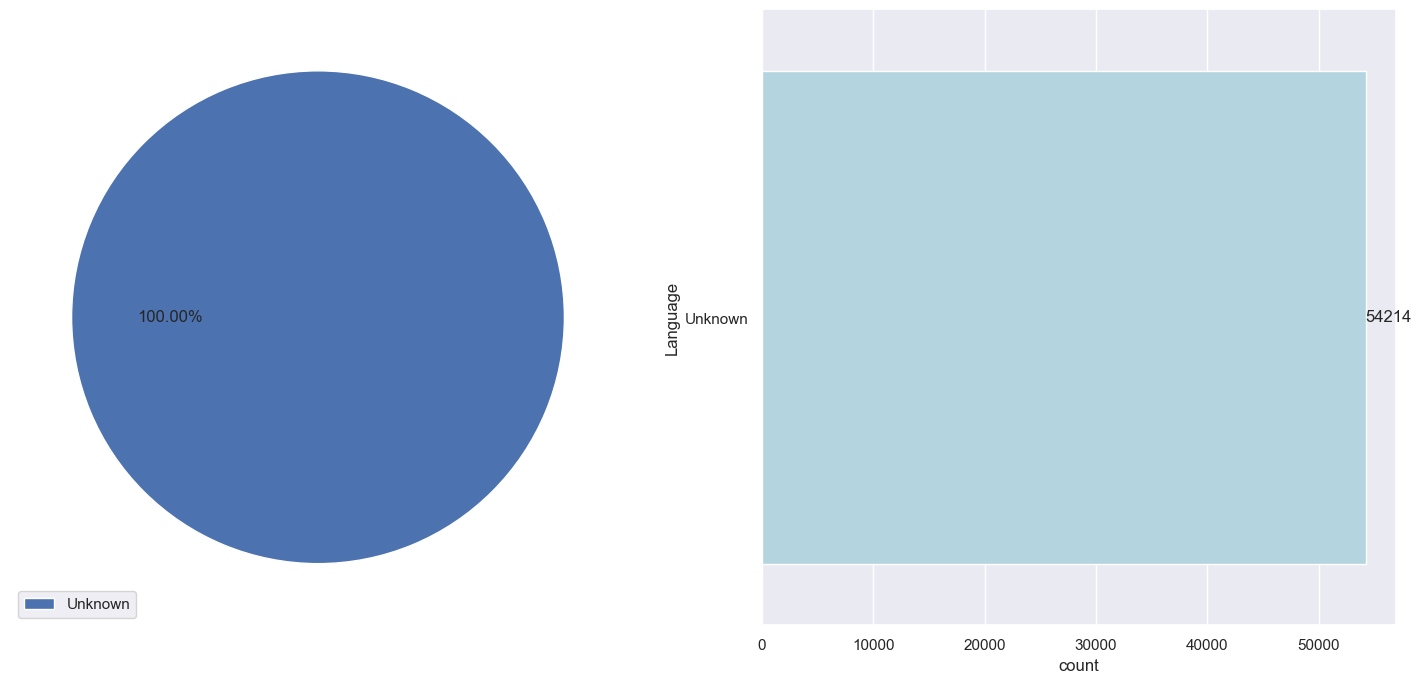

In [22]:
fig,axs = plt.subplots(1,2)
axs[0].pie(train.Language.value_counts().values.tolist(),autopct='%.2f%%')
axs[0].legend(labels=train.Language.value_counts().index.tolist(),loc='lower left')
sns.countplot(data=train,y='Language',order=train.Language.value_counts().index.tolist(),ax=axs[1],color='lightblue')
axs[1].bar_label(axs[1].containers[0])
fig.show()

Observation : We see that there is no other language in our data

In [25]:
#includind the Https Link
train.loc[train['Description'].str.contains(r'http\S+')].shape[0]

9

In [26]:
train.loc[train['Description'].str.contains(r'http\S+')].head()['Description'].iloc[1]

" There's more to the story of the Clintons and 9/11. Over two nights -- September 10-11, 2006, just four months before Hillary announced the exploratory committee for her original presidential campaign, ABC aired The Path to 9/11, a riveting and factual docudrama. This acclaimed and balanced movie faulted two administrations -- Bill Clinton and George W. Bush. But fairness was not what Hillary wanted. Screenwriter Cyrus Nowrasteh told me he had expected the customary DVD distribution. But the Clintons, fearing the impact of DVD release during her campaign, successfully pressured Disney, which owns ABC, to bury the movie. This is a portion of a news article that originally appeared: http://www.frontpagemag.com/fpm/261541/hillarys-path-back-911-arnold-steinberg This article originally appeared in The Huffington Post http://www.huffingtonpost.com/arnold-steinberg/hillarys-path-back-to-911_b_9039658.html This article was written by Arnold Steinberg from Huffington Post and was legally lic

Task 4 : Cleaning Text Function

In [27]:
# we remove strange pattern in differnt language, twitter handler, URLs, punctuationd, numbers, single charachters
def clean_text(text): 
    text = re.sub('Mail <svaradi@sprynet.com> for translation. ','',text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(f'[{string.punctuation}]','',text)
    text = re.sub(f'[{string.digits}]','',text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    return text

In [28]:
#Clean Descriptions
train['Description'] = train['Description'].apply(clean_text)
test['Description'] = test['Description'].apply(clean_text)

In [29]:
train[~train.Language.isin(['english'])]

,Title,Genre,Description,Language
0,Oscar et la dame rose (2009),drama,Listening in to conversation between his doct...,Unknown
1,Cupid (1997),thriller,brother and sister with past incestuous relat...,Unknown
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,Unknown
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,Unknown
4,The Unrecovered (2007),drama,The films title refers not only to the unreco...,Unknown
...,...,...,...,...
54209,"""Bonino"" (1953)",comedy,This shortlived NBC live sitcom centered on B...,Unknown
54210,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION The siste...,Unknown
54211,Ronald Goedemondt: Ze bestaan echt (2008),documentary,Ze bestaan echt is standup comedy about growi...,Unknown
54212,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,Unknown


In [30]:
#Translate other languages
def trans(text):
    try:
        return Translator().translate(text,dest='en').text
    except:
        return text
train.loc[~train['Language'].isin(['english']), 'Description']=train.loc[~train['Language'].isin(['english']),'Description'].apply(trans)
test.loc[~test['Language'].isin(['english']), 'Description']=test.loc[~test['Language'].isin(['english']),'Description'].apply(trans)

In [31]:
train.drop(columns='Language',inplace=True)
test.drop(columns='Language',inplace=True)

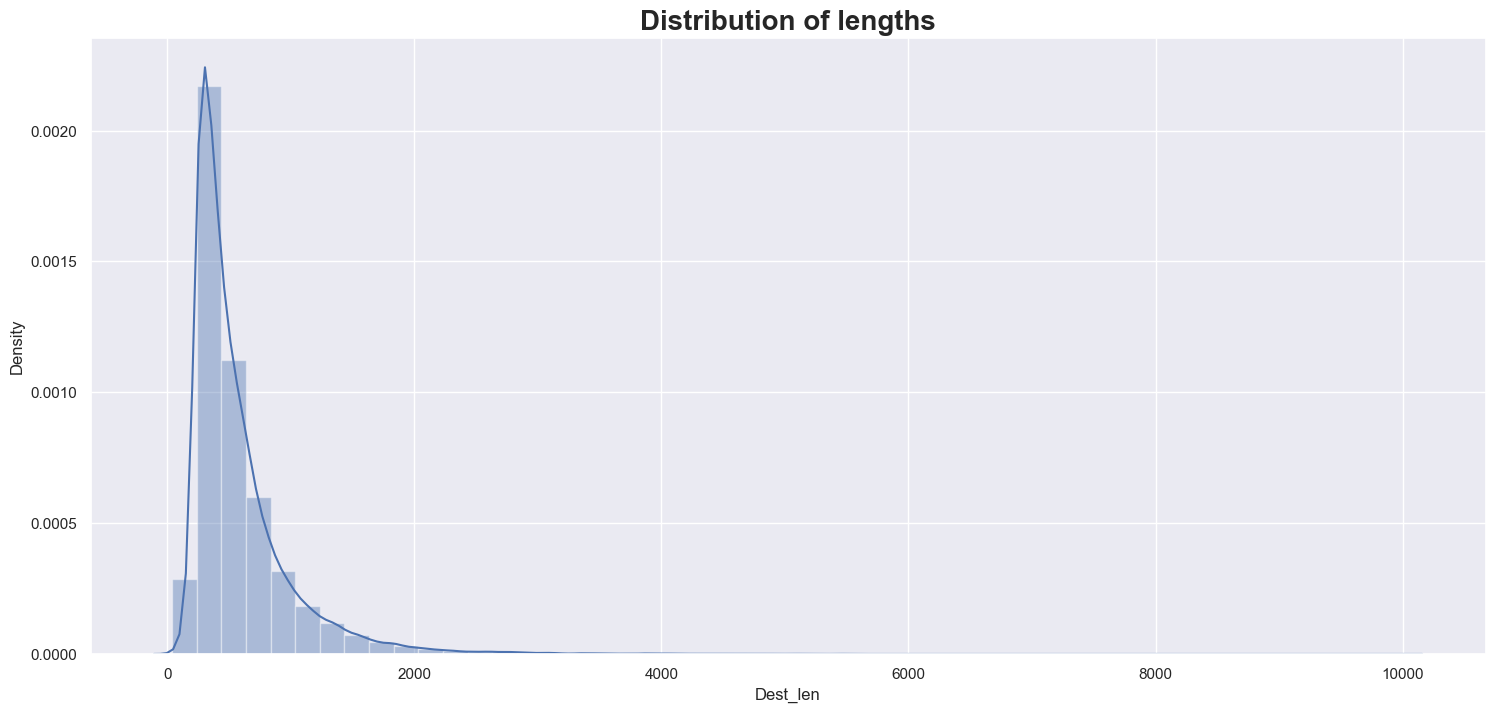

In [32]:
#Distribution of text lengths
train['Dest_len'] = train['Description'].apply(len)
sns.distplot(train['Dest_len'])
plt.title('Distribution of lengths',fontweight='bold',fontsize=20)
plt.show()

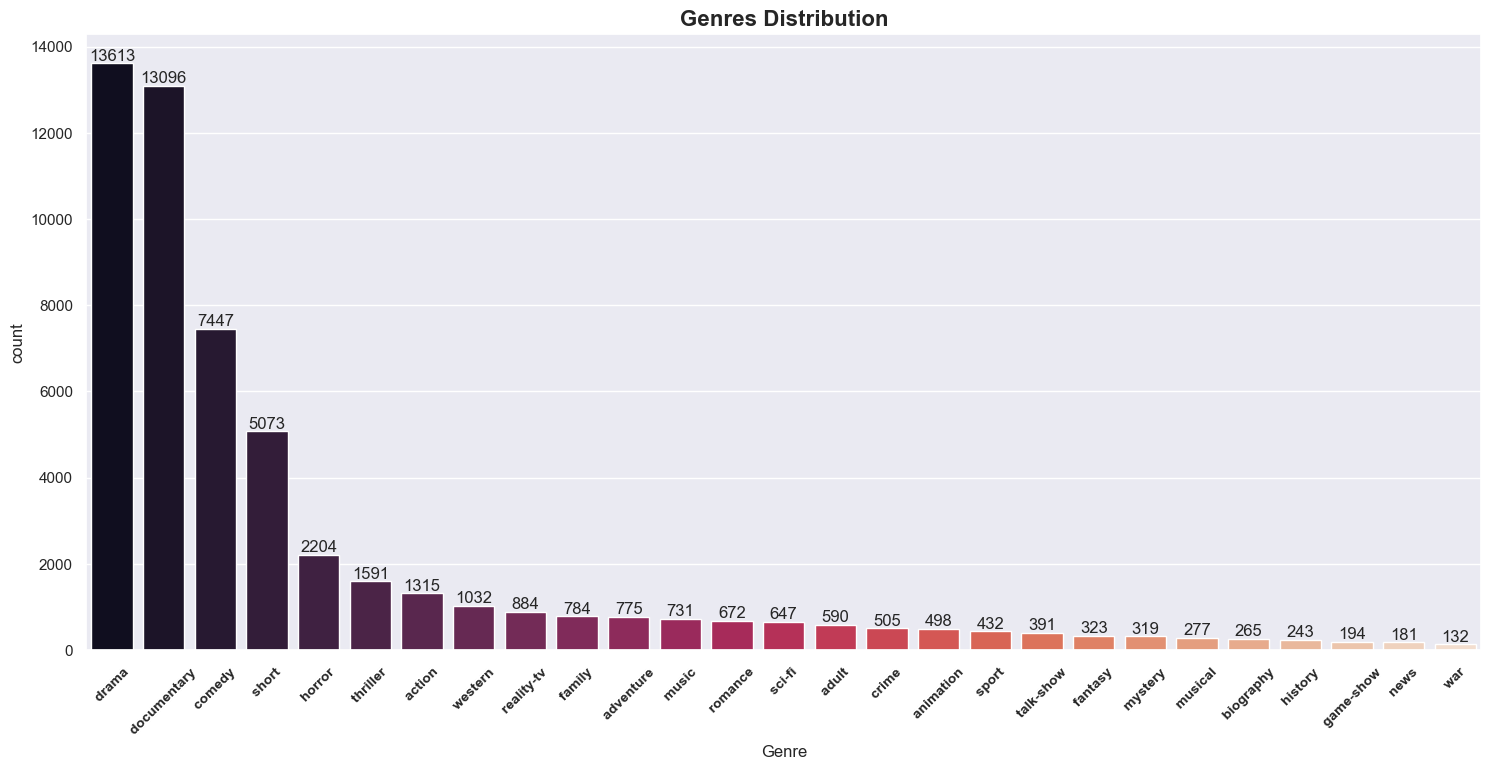

In [33]:
ax=sns.countplot(data=train,x='Genre',order=train.Genre.value_counts().index,palette='rocket')
ax.bar_label(ax.containers[0])
plt.title('Genres Distribution',fontweight='bold',fontsize=16)
plt.xticks(rotation=45,fontweight='bold',fontsize=10)
plt.show()

Task 5 : Model Bulding

In [34]:
# Using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,1), stop_words='english', min_df=2)
x_train = tfidf_vectorizer.fit_transform(train['Description'])
x_test = tfidf_vectorizer.transform(test['Description'])

In [35]:
sampler = RandomOverSampler()
x_train_resampled , y_train_resampled = sampler.fit_resample(x_train,train['Genre'])

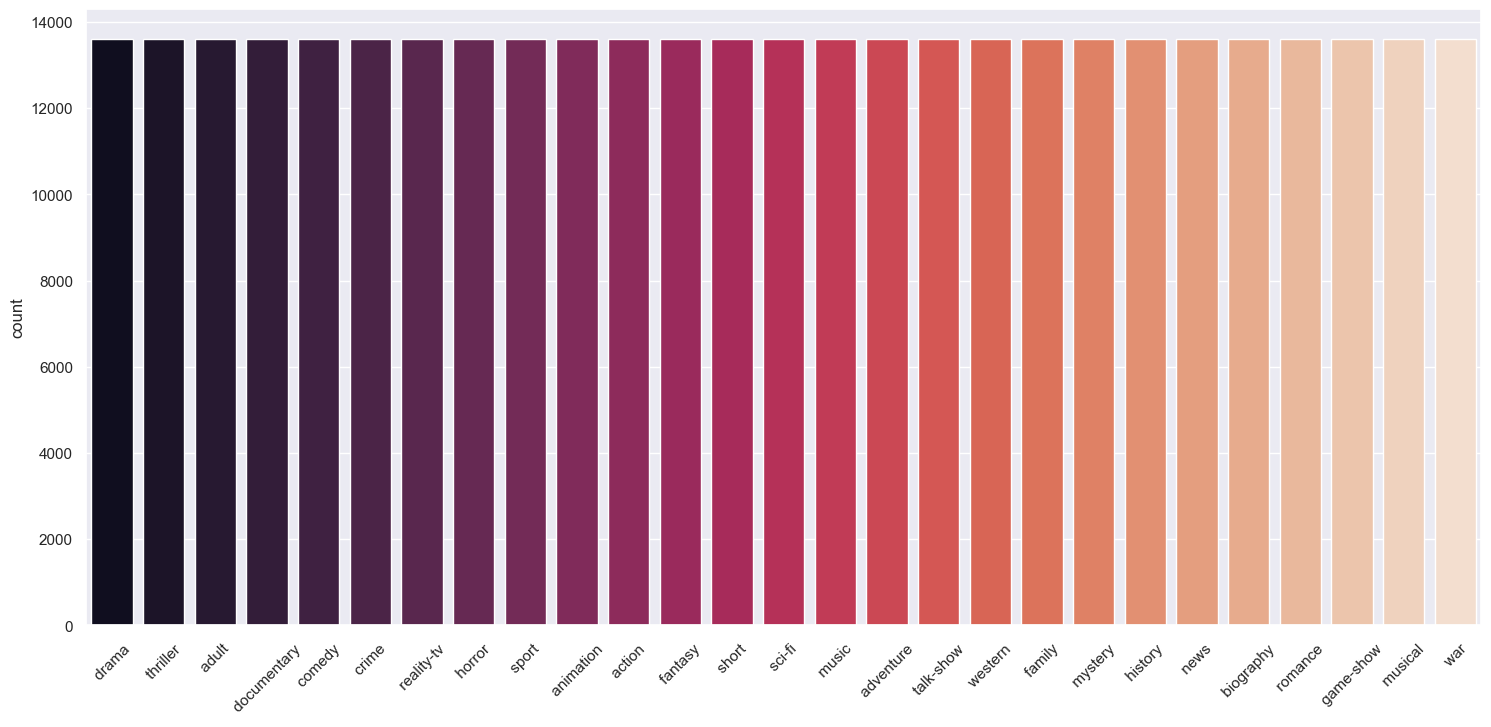

In [36]:
sns.countplot(data=y_train_resampled,x=y_train_resampled.values,palette='rocket')
plt.xticks(rotation=45)
plt.show()

In [37]:
y_actual = pd.read_csv(r"test_data_solution.txt", sep=':::',usecols=[2],header=None).rename(columns={2:'Actual_Genre'})
y_actual.head()

,Actual_Genre
0,thriller
1,comedy
2,documentary
3,drama
4,drama
